### This script checks if all Dataframes have the format WsDateTime, MEASUREMENT and brings them in 5 second alignment.

In [1]:
import os
import re
import pandas as pd
from multiprocessing.dummy import Pool as ThreadPool
from multiprocessing import cpu_count

BASE_DIR   = None
BACKUP_DIR = None

def align_single_file(args):
    filepath, test_mode = args
    rel   = os.path.relpath(filepath, BASE_DIR)
    fname = os.path.basename(filepath)
    root  = os.path.dirname(filepath)

    # 1) extract year
    try:
        year = int(fname.split('_')[0])
    except ValueError:
        print(f"⚠️  Skipping (bad format): {rel}", flush=True)
        return

    print(f"🚧 Starting: {rel} (Year: {year})", flush=True)

    def try_read(path):
        try:
            return pd.read_csv(path, compression='infer')
        except EOFError:
            # fallback to backup
            relp = os.path.relpath(path, BASE_DIR)
            backup_path = os.path.join(BACKUP_DIR, relp)
            df_bak = pd.read_csv(backup_path, compression='infer')
            print(f"🔄 Loaded backup for corrupted file: {rel}", flush=True)
            return df_bak

    try:
        df = try_read(filepath)

        # 2) if missing WsDateTime, reload from backup
        if 'WsDateTime' not in df.columns:
            relp = os.path.relpath(filepath, BASE_DIR)
            backup_path = os.path.join(BACKUP_DIR, relp)
            df = pd.read_csv(backup_path, compression='infer')
            print(f"🔄 Reloaded from backup (missing WsDateTime): {rel}", flush=True)

        if 'WsDateTime' not in df.columns:
            print(f"⚠️  No 'WsDateTime' even in backup, skipping {rel}", flush=True)
            return

        # 3) timestamp + full 5s index
        df['timestamp'] = pd.to_datetime(df['WsDateTime'])
        start = pd.Timestamp(f"{year}-01-01 00:00:00")
        end   = pd.Timestamp(f"{year}-12-31 23:59:55")
        full_range = pd.date_range(start, end, freq='5s')

        # 4) round & dedupe
        df['nearest_5s'] = df['timestamp'].dt.round('5s')
        df['abs_diff']   = (df['timestamp'] - df['nearest_5s']).abs()
        df_valid = (
            df[df['abs_diff'] <= pd.Timedelta(seconds=5)]
              .sort_values('abs_diff')
              .drop_duplicates('nearest_5s')
              .set_index('nearest_5s')
        )

        # 5) pick & clean measurement column
        data_cols = [c for c in df.columns
                     if c not in ('WsDateTime','timestamp','nearest_5s','abs_diff')]
        if not data_cols:
            print(f"⚠️  No data column in {rel}, skipping", flush=True)
            return
        orig  = data_cols[0]
        clean = re.sub(r'^\d+_', '', orig)

        # 6) reindex, rename & reset
        df_out = df_valid[[orig]].rename(columns={orig: clean})
        df_out.index.name = 'WsDateTime'
        df_out = df_out.reindex(full_range).reset_index().rename(columns={'index':'WsDateTime'})

        # 7) save
        if test_mode:
            out = os.path.join(root, fname.replace('.csv.xz','_test.csv.xz'))
            df_out.to_csv(out, index=False, compression='xz')
            print(f"✅ Saved test file: {os.path.relpath(out, BASE_DIR)}", flush=True)
        else:
            df_out.to_csv(filepath, index=False, compression='xz')
            print(f"✅ Overwrote: {rel}", flush=True)

    except Exception as e:
        print(f"❌ Error in {rel}: {e}", flush=True)

def get_all_files(base_dir, start_from=None):
    base_abs   = os.path.abspath(base_dir)
    start_norm = None
    if start_from:
        sf = os.path.normpath(start_from)
        # allow absolute or relative
        if os.path.isabs(sf):
            sf = os.path.relpath(sf, base_abs)
        start_norm = sf

    print(f"🔍 Scanning '{base_dir}' for .csv.xz files…", flush=True)
    files = []
    skipping = start_norm is not None
    skipped_count = 0

    # 1) machine-level: no sort, use scandir order
    for mach_entry in os.scandir(base_abs):
        if not mach_entry.is_dir():
            continue
        mach_path = mach_entry.path

        # 2) measurement-level: no sort
        for meas_entry in os.scandir(mach_path):
            if not meas_entry.is_dir():
                continue
            meas_path = meas_entry.path

            # 3) file-level: sorted lex so years go 2018,2019,…
            fnames = sorted(
                [e.name for e in os.scandir(meas_path) if e.is_file() and e.name.endswith('.csv.xz')]
            )

            for f in fnames:
                full = os.path.join(meas_path, f)
                rel  = os.path.relpath(full, base_abs)

                if skipping:
                    if rel == start_norm:
                        print(f"▶️  Resuming at: {rel} (skipped {skipped_count} files)", flush=True)
                        skipping = False
                    else:
                        skipped_count += 1
                        continue

                files.append(full)

    return files

def run_parallel(
    base_dir="dataset_clean",
    backup_base_dir="dataset",
    start_from=None,
    test_mode=False,
    num_workers=None
):
    global BASE_DIR, BACKUP_DIR
    BASE_DIR   = base_dir
    BACKUP_DIR = backup_base_dir

    files = get_all_files(base_dir, start_from)
    print(f"\n📂 {len(files)} file(s) remaining to process.\n", flush=True)
    if not files:
        return

    workers = num_workers or max(cpu_count() - 1, 1)
    print(f"🧵 Spawning {workers} threads…\n", flush=True)

    tasks = [(fp, test_mode) for fp in files]
    with ThreadPool(processes=workers) as pool:
        pool.map(align_single_file, tasks)

if __name__ == "__main__":
    run_parallel(
        base_dir="dataset_clean",
        backup_base_dir="dataset",
        start_from="EPI_TotalLoad\\Freq\\2018_Freq.csv.xz",
        test_mode=False,num_workers=2
        )

🔍 Scanning 'dataset_clean' for .csv.xz files…


FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: 'd:\\EnergyDataset\\scripts\\dataset_clean'

### In case the script crashed, start with unprocessed files and skipp already processed files

In [ ]:
import os
import re
import pandas as pd
from datetime import datetime, date, time, timedelta
from multiprocessing.dummy import Pool as ThreadPool
from multiprocessing import cpu_count

# ─── CONFIGURATION ────────────────────────────────────────────────────────────
BASE_DIR       = "dataset_clean"
BACKUP_DIR     = "dataset"
# window: from two days ago at 18:00 until today 18:00
today          = date.today()
window_end     = datetime.combine(today, time(18, 0))
window_start   = window_end - timedelta(days=2)
NUM_WORKERS    = 18
TEST_MODE      = False
# ──────────────────────────────────────────────────────────────────────────────

def list_all_files(base_dir):
    base_abs = os.path.abspath(base_dir)
    all_files = []
    for root, _, files in os.walk(base_abs):
        for f in files:
            if f.endswith(".csv.xz"):
                rel = os.path.relpath(os.path.join(root, f), base_abs)
                all_files.append(rel)
    return set(all_files)

def list_processed_files(base_dir, start_dt, end_dt):
    base_abs = os.path.abspath(base_dir)
    proc = []
    for root, _, files in os.walk(base_abs):
        for f in files:
            if not f.endswith(".csv.xz"):
                continue
            full = os.path.join(root, f)
            mtime = datetime.fromtimestamp(os.path.getmtime(full))
            if start_dt <= mtime <= end_dt:
                rel = os.path.relpath(full, base_abs)
                proc.append(rel)
    return set(proc)

# ─── your existing align_single_file ↓ unchanged ─────────────────────────────
def align_single_file(args):
    filepath, test_mode = args
    rel   = os.path.relpath(filepath, BASE_DIR)
    fname = os.path.basename(filepath)
    root  = os.path.dirname(filepath)

    try:
        year = int(fname.split('_')[0])
    except ValueError:
        print(f"⚠️  Skipping (bad format): {rel}", flush=True)
        return

    print(f"🚧 Starting: {rel} (Year: {year})", flush=True)

    def try_read(path):
        try:
            return pd.read_csv(path, compression='infer')
        except EOFError:
            relp        = os.path.relpath(path, BASE_DIR)
            backup_path = os.path.join(BACKUP_DIR, relp)
            df_bak      = pd.read_csv(backup_path, compression='infer')
            print(f"🔄 Loaded backup for corrupted file: {rel}", flush=True)
            return df_bak

    try:
        df = try_read(filepath)

        if 'WsDateTime' not in df.columns:
            relp        = os.path.relpath(filepath, BASE_DIR)
            backup_path = os.path.join(BACKUP_DIR, relp)
            df          = pd.read_csv(backup_path, compression='infer')
            print(f"🔄 Reloaded from backup (missing WsDateTime): {rel}", flush=True)

        if 'WsDateTime' not in df.columns:
            print(f"⚠️  No 'WsDateTime' even in backup, skipping {rel}", flush=True)
            return

        df['timestamp'] = pd.to_datetime(df['WsDateTime'])
        start = pd.Timestamp(f"{year}-01-01 00:00:00")
        end   = pd.Timestamp(f"{year}-12-31 23:59:55")
        full_range = pd.date_range(start, end, freq='5s')

        df['nearest_5s'] = df['timestamp'].dt.round('5s')
        df['abs_diff']   = (df['timestamp'] - df['nearest_5s']).abs()
        df_valid = (
            df[df['abs_diff'] <= pd.Timedelta(seconds=5)]
              .sort_values('abs_diff')
              .drop_duplicates('nearest_5s')
              .set_index('nearest_5s')
        )

        data_cols = [c for c in df.columns
                     if c not in ('WsDateTime','timestamp','nearest_5s','abs_diff')]
        if not data_cols:
            print(f"⚠️  No data column in {rel}, skipping", flush=True)
            return
        orig  = data_cols[0]
        clean = re.sub(r'^\d+_', '', orig)

        df_out = df_valid[[orig]].rename(columns={orig: clean})
        df_out.index.name = 'WsDateTime'
        df_out = df_out.reindex(full_range)\
                       .reset_index()\
                       .rename(columns={'index':'WsDateTime'})

        if test_mode:
            out = os.path.join(root, fname.replace('.csv.xz','_test.csv.xz'))
            df_out.to_csv(out, index=False, compression='xz')
            print(f"✅ Saved test file: {os.path.relpath(out, BASE_DIR)}", flush=True)
        else:
            df_out.to_csv(filepath, index=False, compression='xz')
            print(f"✅ Overwrote: {rel}", flush=True)

    except Exception as e:
        print(f"❌ Error in {rel}: {e}", flush=True)


In [ ]:
if __name__ == "__main__":
    # 1) build sets
    all_files      = list_all_files(BASE_DIR)
    processed      = list_processed_files(BASE_DIR, window_start, window_end)
    missing_rels   = sorted(all_files - processed)

    print(f"Time window: {window_start} → {window_end}")
    print(f"✅ Found {len(processed)} processed files")
    print(f"❌ {len(missing_rels)} missing of {len(all_files)} total:\n")
 
    # 2) turn to absolute paths & process only missing
    tasks = [(os.path.join(os.path.abspath(BASE_DIR), rel), TEST_MODE) for rel in missing_rels]

    workers = max(cpu_count() - 1, 1) if NUM_WORKERS is None else NUM_WORKERS
    print(f"\n🧵 Spawning {workers} threads to reprocess missing…\n", flush=True)

    with ThreadPool(processes=workers) as pool:
        pool.map(align_single_file, tasks)

## Manual Checks

In [ ]:
"""
..\dataset_clean\EPI_TotalLoad\Freq\2018_Freq.csv.xz
..\dataset_clean\EPI_TotalLoad\Freq\2019_Freq.csv.xz

..\dataset_clean\TEC_48S\LoadType1\2024_LoadType1.csv.xz

..\dataset_clean\EPI_TotalLoad\U12_h31\2021_U12_h31.csv.xz
"""

In [24]:
file_path = r"..\dataset_clean\EPI_TotalLoad\U12_h31\2021_U12_h31.csv.xz"

try:
    df = pd.read_csv(file_path)
    df.plot()
except Exception as e:
    print(f"Not readable")

Not readable


In [25]:
import os

# --- point these to your roots ---
BASE_DIR   = os.path.abspath(r"..\dataset_clean")
BACKUP_DIR = os.path.abspath(r"..\dataset")

# your target file (relative or absolute is fine)
target_rel = file_path
target_abs = os.path.abspath(target_rel)

# IMPORTANT: don't run in test mode if you want to overwrite
TEST_MODE = False

# reuse your existing function
align_single_file((target_abs, TEST_MODE))

🚧 Starting: EPI_TotalLoad\U12_h31\2021_U12_h31.csv.xz (Year: 2021)
🔄 Loaded backup for corrupted file: EPI_TotalLoad\U12_h31\2021_U12_h31.csv.xz
✅ Overwrote: EPI_TotalLoad\U12_h31\2021_U12_h31.csv.xz


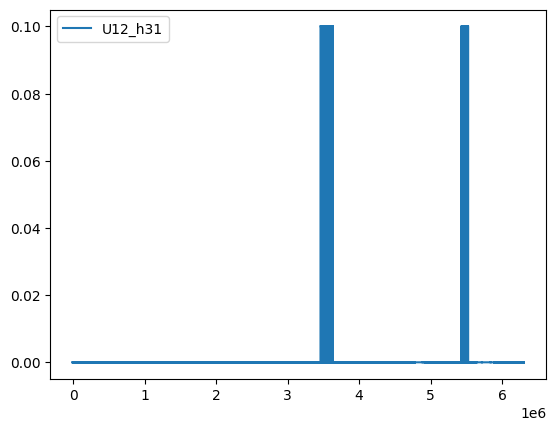

In [26]:
try:
    df = pd.read_csv(file_path)
    df.plot()
except Exception as e:
    print(f"Not readable")